In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader

from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from torchfitter.regularization import L1Regularization

from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
X = np.load(DATA_PATH / "features.npy")
y = np.load(DATA_PATH / "labels.npy")

y = y.reshape(-1,1)

In [5]:
from sklearn.datasets import make_regression

In [6]:
# simplest case of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42
)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = nn.Linear(in_features=1, out_features=1)
model.to(device)

regularizer = L1Regularization(regularization_rate=0.01, biases=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [9]:
from torchfitter.callbacks import LoggerCallback, EarlyStopping

In [10]:
logger = LoggerCallback(update_step=50)
early_stopping = EarlyStopping(patience=50, load_best=True)

In [11]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    regularizer=regularizer,
    device=device,
    callbacks=[logger, early_stopping]
)

In [12]:
# wrap data in Dataset
train_wrapper = DataWrapper(
    X_train, 
    y_train, 
    dtype_X='float', 
    dtype_y='float'
)
val_wrapper = DataWrapper(X_val, y_val, dtype_X='float', dtype_y='float')

# torch Loaders
train_loader = DataLoader(train_wrapper, batch_size=32)
val_loader = DataLoader(val_wrapper, batch_size=32)

In [13]:
# fitting process
trainer.fit(train_loader, val_loader, epochs=5000)

INFO:root:Starting training process on cpu


INFO:root:Epoch: 0/5000     | Train loss: 8433.490211   | Validation loss: 8433.490211   | Time/epoch: 0.026350     
INFO:root:Epoch: 1/5000     | Train loss: 8429.580636   | Validation loss: 8429.580636   | Time/epoch: 0.025430     
INFO:root:Epoch: 50/5000     | Train loss: 8241.995698   | Validation loss: 8241.995698   | Time/epoch: 0.016890     
INFO:root:Epoch: 100/5000     | Train loss: 8054.200707   | Validation loss: 8054.200707   | Time/epoch: 0.017910     
INFO:root:Epoch: 150/5000     | Train loss: 7869.563035   | Validation loss: 7869.563035   | Time/epoch: 0.019110     
INFO:root:Epoch: 200/5000     | Train loss: 7687.801293   | Validation loss: 7687.801293   | Time/epoch: 0.017710     
INFO:root:Epoch: 250/5000     | Train loss: 7508.732329   | Validation loss: 7508.732329   | Time/epoch: 0.017980     
INFO:root:Epoch: 300/5000     | Train loss: 7332.233887   | Validation loss: 7332.233887   | Time/epoch: 0.016990     
INFO:root:Epoch: 350/5000     | Train loss: 7158.2276

INFO:root:Epoch: 3400/5000     | Train loss: 603.156937    | Validation loss: 603.156937    | Time/epoch: 0.018900     
INFO:root:Epoch: 3450/5000     | Train loss: 559.750525    | Validation loss: 559.750525    | Time/epoch: 0.017290     
INFO:root:Epoch: 3500/5000     | Train loss: 518.382145    | Validation loss: 518.382145    | Time/epoch: 0.016220     
INFO:root:Epoch: 3550/5000     | Train loss: 479.021502    | Validation loss: 479.021502    | Time/epoch: 0.017710     
INFO:root:Epoch: 3600/5000     | Train loss: 441.671100    | Validation loss: 441.671100    | Time/epoch: 0.016770     
INFO:root:Epoch: 3650/5000     | Train loss: 406.313013    | Validation loss: 406.313013    | Time/epoch: 0.016940     
INFO:root:Epoch: 3700/5000     | Train loss: 372.961580    | Validation loss: 372.961580    | Time/epoch: 0.017660     
INFO:root:Epoch: 3750/5000     | Train loss: 341.586760    | Validation loss: 341.586760    | Time/epoch: 0.017300     
INFO:root:Epoch: 3800/5000     | Train l

In [14]:
from torchfitter.conventions import ParamsDict

In [15]:
# predictions
with torch.no_grad():
    y_pred = model(torch.from_numpy(X_val).float().to(device)).cpu().numpy()

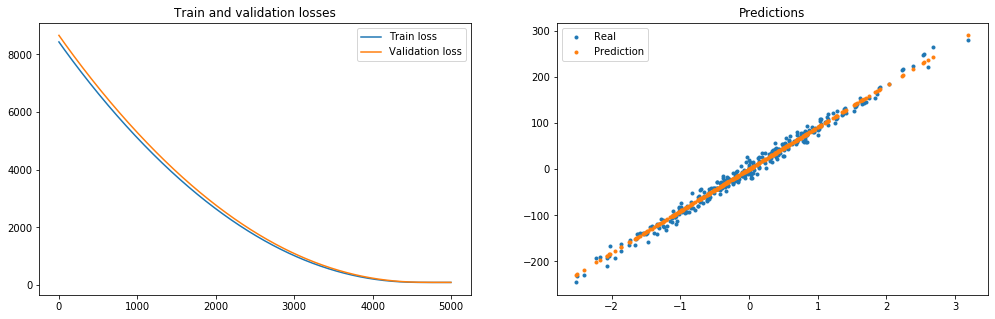

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5))

ax[0].plot(trainer.params_dict['history']['train_loss'], label='Train loss')
ax[0].plot(trainer.params_dict['history']['validation_loss'], label='Validation loss')
ax[0].set_title('Train and validation losses')
ax[0].legend();

ax[1].plot(X_val, y_val, '.', label="Real")
ax[1].plot(X_val, y_pred, '.', label="Prediction")
ax[1].set_title('Predictions')
ax[1].legend();